# Определение стоимости автомобилей

В данном проекте мы будем разрабатывать приложение для определения стоимости автомобиля на основе существующей базы.

Мы будем работать с датафреймом, в котором находятся различные параметры автомобиля: модель, тип топлива, год регистрации и другие.

Для начала изучим данные и проведем их подготовку: проверим на пропуски и дубликаты, и при необходимости исправим.

После этого проанализируем данные, выявим аномалии и удалим их.

Далее мы разобьем наши данные на тренировочную, валидационную и тестовую выборки. И с помощью различных моделей, а именно LightGBM, CatBoost и LinearRegression с различными гиперпараметрами проведем моделирование.

После всех расчетов, сравним показатели моделей, а именно - качество предсказания по метрике RMSE, а также оценим скорость предсказания и время обучения моделей.

В конечном итоге посоветуем заказчику оптимальную модель для решения задачи предсказания стоимости автомобилей.


In [30]:
!pip install --upgrade scikit-learn==1.2.2
!pip install catboost
!pip install lightgbm
!pip install phik

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

import time

In [32]:
RANDOM_STATE = 42

## Подготовка данных

### Загрузка данных

In [33]:
try:
    autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    autos = pd.read_csv('C/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Посмотрим на нашу базу автомобилей.

In [34]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [35]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Во-первых, присутствуют столбцы, которые никак не помогут нам в прогнозировании цены автомобиля, поэтому их стоит удалить для большей компактности нашей базы автомобилей. Это колонки 'DateCrawled' (содержит дату скачивания анкеты из базы), 'PostalCode' (индекс владельца авто), 'LastSeen' (дата последнего захода пользователя).

Во-вторых, наш датафрейм нуждается в преобразовании названий колонок к змеиному регистру. Это будет более правильно.

В-третьих, колонку 'DateCreated' можно заменить на 2 других: на год и месяц объявления.

Последнее, что бросается в глаза - это пропуски. Наш датафрейм состоит из 354369 строк, но в некоторых колонках имеются пропуски, их необходимо заменить. Далее будем смотреть по каждой колонке, какими значениями корректней будет заполнить пропуски.


### Предобработка данных

#### Удаление неинформативных колонок, преобразование датафрейма к змеиному регистру.

In [36]:
autos = autos.drop(columns=['DateCrawled', 'PostalCode', 'LastSeen'], axis=1)

In [37]:
#autos.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
#       'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired',
#       'date_created', 'number_of_pictures']

In [38]:
autos = autos.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())  

#### Создание новых колонок

Выделим из колонки 'date_created' год и месяц объявления.

In [39]:
#autos['date_created'] = pd.to_datetime(autos['date_created']).dt.floor('d')
autos['year_created'] = autos['date_created'].dt.year
autos['month_created'] = autos['date_created'].dt.month

#### Пропуски и дубликаты

Посмотрим на количество пропусков в колонках.

In [40]:
autos.isna().sum().sort_values(ascending=False)

repaired              71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
year_created              0
month_created             0
dtype: int64

In [41]:
#код ревьюера
!pip install missingno -q
import missingno as msno

autos.isna().sum().sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm', axis=0).set_precision(2)



,0
repaired,71154
vehicle_type,37490
fuel_type,32895
gearbox,19833
model,19705
price,0
registration_year,0
power,0
kilometer,0
registration_month,0


Пропусков достаточно много. Наибольшее количество в колонке 'repaired' - больше 70 тысяч. Также в колонках 'vehicle_type' и 'fuel_type' присутсвуют 30-40 тысяч пропусков. Чуть меньше пропусков (около 20 тысяч) в колонках 'gearbox' и 'model'.

Также посмотрим на уникальные значения в некоторых колонках, нет ли там значений с опечатками и тп, которые создадут нам лишние класcы.

In [42]:
columns = autos.select_dtypes(include='object').columns.tolist()
for column in columns:
    print(column, ':', autos[column].unique())
    print()

vehicle_type : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

gearbox : ['manual' 'auto' nan]

model : ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider

Опечатки отсутствуют.

Теперь будем заполнять пропуски. Начнем с колонки 'repaired'. Проведем аналитику.

In [43]:
autos['repaired'].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: repaired, dtype: float64

Меньше 13% машин были в ремонте. Можем посмотреть средний пробег и тех, и других машин.

In [44]:
print('Средний пробег автомобиля, который был в ремонте:',
autos.loc[autos['repaired'] == 'yes', 'kilometer'].mean())
print('Средний пробег автомобиля, который не был в ремонте:',
autos.loc[autos['repaired'] == 'no', 'kilometer'].mean())
print('Зона разделения:',
(autos.loc[autos['repaired'] == 'yes', 'kilometer'].mean() + autos.loc[autos['repaired'] == 'no', 'kilometer'].mean()) / 2)

Средний пробег автомобиля, который был в ремонте: 136178.09397015587
Средний пробег автомобиля, который не был в ремонте: 126395.58830074324
Зона разделения: 131286.84113544956


Видно, что чем больше пробег, тем вероятнее, что машина была в ремонте. Заполним пропущенные значения на основе пробега. Если он больше или равен 131286 км, то будем считать, что машина была в ремонте, а если меньше, то нет.

In [45]:
autos.loc[(autos['kilometer'] >= 131286) & (autos['repaired'].isna()), 'repaired'] = 'yes'
autos.loc[(autos['kilometer'] < 131286) & (autos['repaired'].isna()), 'repaired'] = 'no'

In [46]:
autos['repaired'].isna().sum()

0

Пропуски в графе ремонт заполнены. 

Перейдем к столбцу 'model'. Его будем заполнять на основании марки автомобиля. Посмотрим модель какой марки отсутствует и заполним пропуск самой частовстречаемом машиной этого бренда. Создадим универсальную функцию, которая поможет нам в дальнейшем.

In [47]:
#c помощью этой функции мы заполним неизвестный признак самым частовтречающимся значением другого признака. 
#рассмотрим на примере модели машины (здесь колонка model - feature, а brand - column)

#для начала заполним пропуски значением 'unknown'. это нужно для того, чтобы когда мы искали моду, если вдруг окажется, что все значения nan, 
#чтобы не было ошибки при извлечении 0 элемента.

#пройдемся циклом по всем брендам. и если в графе марки значение 'unknown', то заменим его на моду этого бренда

#заменим оставшиеся значения 'unknown' на 'other', которые изначально уже есть.    
def fill_moda(df, feature, column):
    df[feature] = df[feature].fillna('unknown')
    for i in df[column].unique():
        df.loc[(df[column] == i) & (df[feature] == 'unknown'), feature] = df.loc[df[column] == i, feature].mode().iloc[0]
    df.loc[df[feature] == 'unknown', feature] = 'other'    

In [28]:

# код ревьюера
data = {'Category': ['A', 'A', 'B', 'B', 'A', 'B', 'A', 'B'],
        'Subcategory': ['X', 'Y', 'X', 'Y', 'X', 'X', 'Y', 'Y'],
        'Value': [10, 12, np.nan, 16, 11, 15, np.nan, 17]}  # Добавляем NaN
df = pd.DataFrame(data)

display("Исходный DataFrame:\n", df)

# Заполняем пропущенные значения средним по Category и Subcategory
df['Value'] = df['Value'].fillna(df.groupby(['Category', 'Subcategory'])['Value'].transform('mean'))

display("\nDataFrame после заполнения пропущенных значений:\n", df)

'Исходный DataFrame:\n'

,Category,Subcategory,Value
0,A,X,10.0
1,A,Y,12.0
2,B,X,NaN
3,B,Y,16.0
4,A,X,11.0
5,B,X,15.0
6,A,Y,NaN
7,B,Y,17.0


'\nDataFrame после заполнения пропущенных значений:\n'

,Category,Subcategory,Value
0,A,X,10.0
1,A,Y,12.0
2,B,X,15.0
3,B,Y,16.0
4,A,X,11.0
5,B,X,15.0
6,A,Y,12.0
7,B,Y,17.0


In [18]:
fill_moda(autos, 'model', 'brand')

Пропуски в колонке моделей устранили. Теперь перейдем к типу кузова. Здесь можно отталкиваться от модели машины. Если тип кузова не известен, то запишем самый часто встречающийся тип кузова для этой модели.

In [19]:
fill_moda(autos, 'vehicle_type', 'model')

Осталось разобраться с типом коробки и типом топлива. Их будем присваивать также исходя из модели автомобиля.

In [20]:
fill_moda(autos, 'fuel_type', 'model')
fill_moda(autos, 'gearbox', 'model')

In [21]:
autos.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
year_created          0
month_created         0
dtype: int64

Пропуски заполнены.

Теперь взглянем на дубликаты. 

In [22]:
autos.duplicated().sum()

12782

Дубликатов получилось достаточно много в абсолютном значении. Но в процентном это 12782 / 354369 = 0.036. То есть меньше 3% от нашей базы. Поэтому смело избавимся от них.

In [23]:
autos = autos.drop_duplicates().reset_index(drop=True)

#### Вывод

Предобработка данных успешна завершена. Неинформативные признаки и дубликаты были удалены. Колонки с датами привидены к нужному формату. Пропуски заполнены самыми частовстречающимся значениями в соответствующих классах.

###  Исследовательский анализ данных

Теперь проведем небольшой анализ данных, для выявления экстремальных значений.

In [24]:
#выделим числовые колонки
num_col = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures']
#выделим категориальные колонки
cat_col = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

In [25]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,year_created,month_created
count,341587.000000,341587.000000,341587.000000,341587.000000,341587.000000,341587.0,341587.000000,341587.000000
mean,4397.878019,2004.227655,110.030505,128261.131132,5.700533,0.0,2015.999933,3.160697
std,4511.125462,91.248289,192.102845,37913.159357,3.728712,0.0,0.008555,0.375716
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,2014.000000,1.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,2016.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,2016.000000,3.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,2016.000000,3.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,2016.000000,12.000000


Теперь визуализируем наши числовые колонки при помощи функции.

In [26]:
def num_feature_plot(df, num_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ЧИСЛОВЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список числовых колонок
    и для каждой колонки строит график boxplot()
    '''
    plt.figure(figsize=(16, 12))
    plt.suptitle('Распределение числовых признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in num_col:
        plt.subplot(2, 3, c)
        sns.boxplot(data=df, x=column)
        c+=1
    plt.show() 

In [27]:
def cat_feature_plot(df, cat_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список категориальных колонок
    и для каждой колонки строит график countplot()
    если количество уникальных значений в колонке больше 4х, то переворачивает на 90 имена категорий, чтобы ничего не 
    накладывалось друг на друга
    '''
    plt.figure(figsize=(16, 12))
    plt.suptitle('Распределение категориальных признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in cat_col:
        if (len(df[column].unique()) > 4) and (df[column].dtype == 'O'):
            plt.subplot(2, 3, c)
            plt.ylabel('количество')
            plt.xticks(rotation=90)
            plt.xlabel('')
            sns.countplot(x=df[column])
        else:
            plt.subplot(2, 3, c)
            plt.ylabel('количество')
            plt.xticks(rotation=0)
            plt.xlabel('')
            sns.countplot(x=df[column])
        c+=1
    plt.show()  

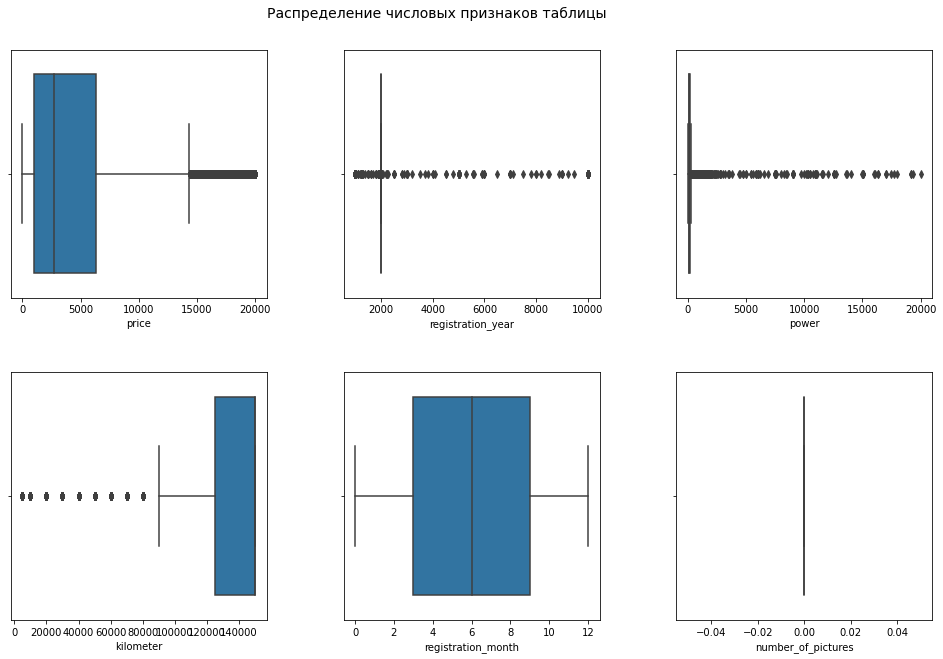

In [28]:
num_feature_plot(autos, num_col)

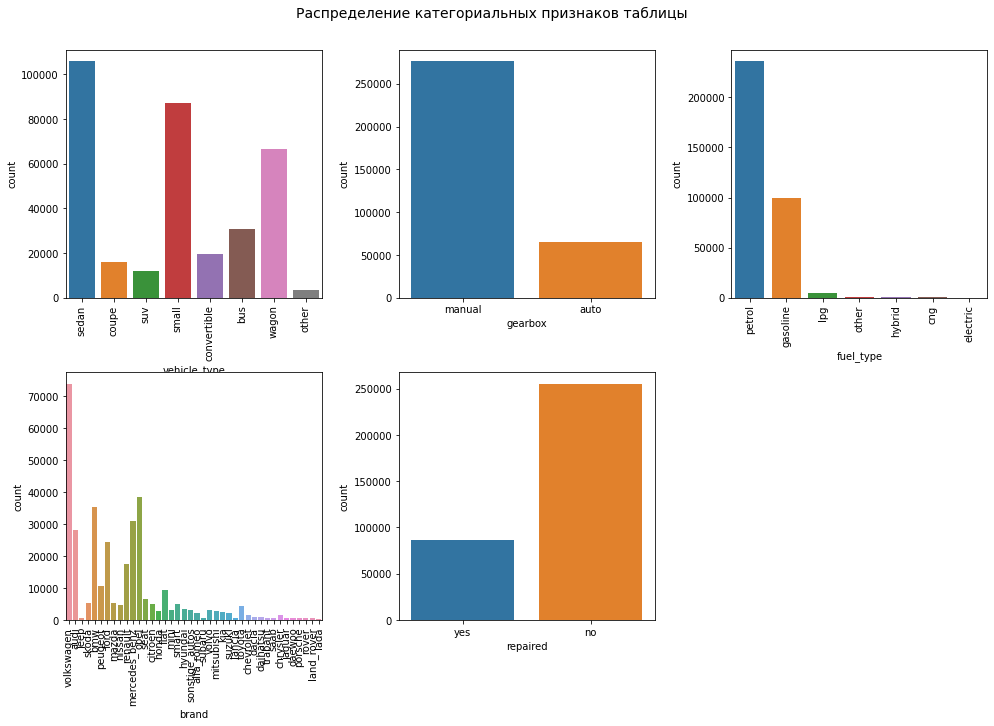

In [29]:
cat_feature_plot(autos, cat_col)

Графики помогли определить нам несколько особенностей. Начнем с конца. Видно, что колонка 'number_of_pictures' содержит лишь 0, поэтому для нас она не информативна и стоит от нее избавиться.

Также не особо информативны для нас колонки 'registration_month', 'month_created', 'year_created', поэтому их тоже удалим.


По остальным колонкам видны экстремальные значения. Например колонка 'power': можно исключить все строки, где ее значения выше 1000. И там где 0, заменить на медианное значение всей колонки. В колонке 'registration_year' есть года, когда еще и не существовало машин, а также года, которые не наступили. Поэтому следует исключить строки, где год регистрации ниже, чем 1900 и выше, чем 2016, тк самый высокий год выкладывания объявления - 2016. А также исключим автомобили, стоимость которых ниже 100 евро.

В пробеге и стомости аномалий нет.

Так же видно, что в типе топлива преобладают 'petrol' и 'gasoline', что в принципе одно и тоже. Поэтому заменил 'gasoline' на 'petrol'.

И теперь разберемся с экстремальными значениями.

In [30]:
autos = autos[autos['power'] <= 1000]
autos.loc[autos['power'] == 0, 'power'] = autos['power'].median()

autos = autos[(autos['registration_year'] >= 1900) & (autos['registration_year'] <= 2016)]
autos = autos[autos['price'] >= 100]
autos.loc[autos['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'
autos = autos.reset_index(drop=True)

In [31]:
autos = autos.drop(['number_of_pictures', 'registration_month', 'month_created', 'year_created', 'date_created'], axis=1)

In [32]:
print('Процент удаленных строк:', round((1 - autos.shape[0] / 354369) * 100, 2))

Процент удаленных строк: 11.1


In [33]:
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,104.0,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190.0,a4,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


Неинформативные колонки удалены.

#### Вывод

Мы посмотрели на наши числовые значения. Удалили строки, содержащие аномальные  значения в колонках 'power', 'registration_year' и 'price'. А также заменили неявные дубликаты в колонке 'fuel_type'. При этом наш датафрейм уменьшился на 11%.

### Матрица корреляции датафрейма 'autos'

Рассмотрим матрицу корреляции между всеми признаками таблицы. Посколько присутсвтуют категориальные признаки, то для построения матрицы корреляции будем использовать библиотеку phik. Предварительно составим список численных и категориальных колонок.

In [34]:
num_col = ['price', 'registration_year', 'power', 'kilometer']
cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [35]:
# считаем корреляции нашего датафрейма для всего кроме первой колонки (id)
phik_overview = autos.phik_matrix(interval_cols=num_col)
print(phik_overview.shape)

(10, 10)


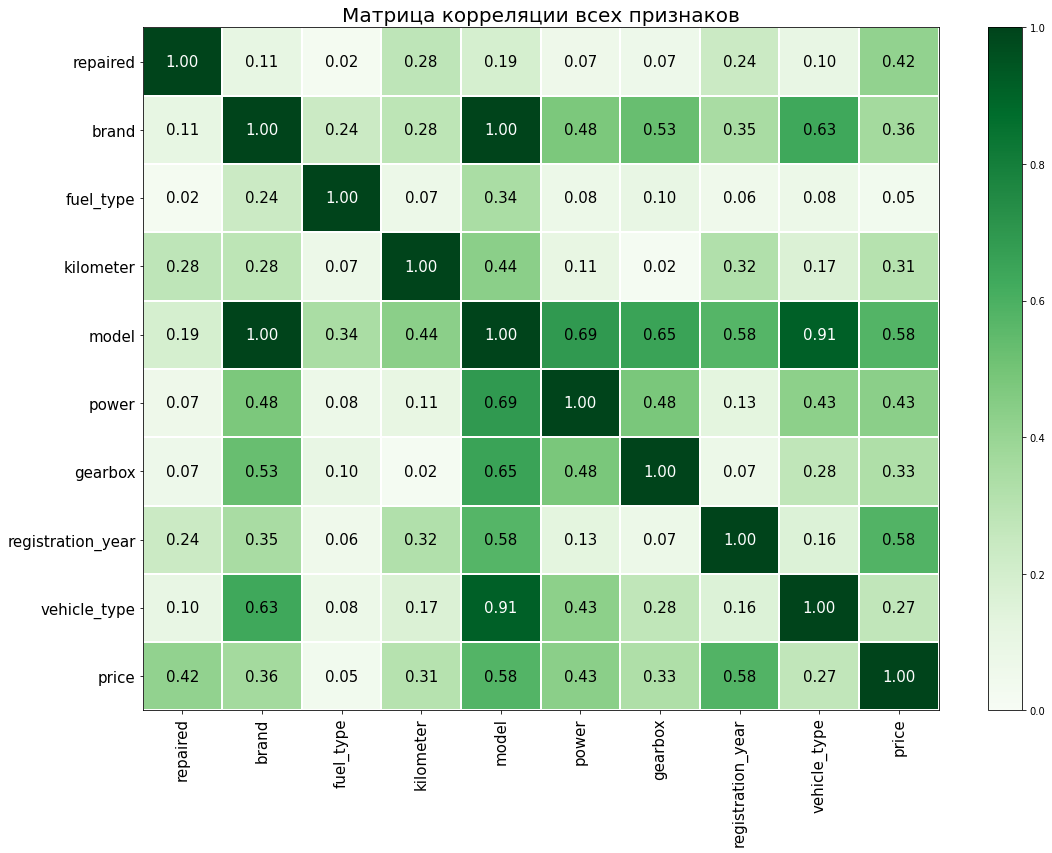

In [36]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(16, 12)
) 
plt.title('Матрица корреляции всех признаков', fontsize = 20)
plt.show()

Мультиколлинеарность наблюдается между брендом и моделью. Модель - это более точная харакетристика, чем бренд, поэтому для дальнейшей работы избавимся от колонки 'brand'. Высокая взаимосвязь наблюдается между моделью машины и типом кузова. На стоимость автомобиля сильнее всего влияют модель, год регистрации, количество лошадиных сил и была ли машина в ремонте.

In [37]:
autos = autos.drop(['brand'], axis=1)

In [38]:
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,480,sedan,1993,manual,104.0,golf,150000,petrol,yes
1,18300,coupe,2011,manual,190.0,a4,125000,petrol,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,no


### Оптимизация датафрейма 'autos'

In [39]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [40]:
optimize_memory_usage(autos)

Размер использования памяти: до 21.63 Mb - после 15.62 Mb (27.8%)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,480,sedan,1993,manual,104.0,golf,150000,petrol,yes
1,18300,coupe,2011,manual,190.0,a4,125000,petrol,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,no
...,...,...,...,...,...,...,...,...,...
315018,3200,sedan,2004,manual,225.0,leon,150000,petrol,yes
315019,2200,sedan,2005,manual,104.0,other,20000,petrol,no
315020,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,no
315021,9200,bus,1996,manual,102.0,transporter,150000,petrol,no


###  Подготовка выборок

Поделим наши данные на 3 выборки: тренировочную, валидационную и тестовую в отношении 80/10/10.

In [41]:
autos_train, autos_test = train_test_split(autos, test_size=0.2, random_state=RANDOM_STATE)
#autos_valid, autos_test = train_test_split(autos_test, test_size=0.5, random_state=RANDOM_STATE)

In [42]:
X_train = autos_train.drop(['price'], axis=1)
y_train = autos_train['price']

X_test = autos_test.drop(['price'], axis=1)
y_test = autos_test['price']

## Обучение моделей

###  Кодирование признаков

Создадим пайплайн для обработки данных. Будем обрабатывать категориальные неранговые колонки при помощи OneHotEncoder(), категориальные ранговые с помощью OrdinalEncoder(), а непрерывные числовые при помощи MinMaxScaler().

In [43]:
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,480,sedan,1993,manual,104.0,golf,150000,petrol,yes
1,18300,coupe,2011,manual,190.0,a4,125000,petrol,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,no


In [44]:
# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'model', 'fuel_type']
ord_columns = ['gearbox', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories = [
                    ['manual', 'auto'],
                    ['yes', 'no']
                ],                  
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),  
     ('ord', ord_pipe, ord_columns),   
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Теперь при помощи нашего препроцессора преобразуем наши датафреймы. По итогу получатся датафреймы, состоящие только из чисел. И далее мы скормим их нашим моделям.

In [45]:
X_train_enc = data_preprocessor.fit_transform(X_train)
X_test_enc = data_preprocessor.transform(X_test)

###  Модель LightGBM

Начнем тестирование с модели LightGBM. Зададим различные гиперпараметры для модели и при помощи RandomizedSearchCV найдем самые лучшие. В оценке будем использовать метрику RMSE.

In [46]:
model_lgbm = lgb.LGBMRegressor()

params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [31, 63, 98, 127],
    'max_depth' : [-1, 3, 5, 7, 12],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1],
    'n_jobs': [-1, 1],
    'random_state': [RANDOM_STATE]
    }

grid = RandomizedSearchCV(model_lgbm, params, cv=5, n_jobs = -1, n_iter=10, random_state=RANDOM_STATE)
grid.fit(X_train_enc, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8],
                                        'bagging_freq': [5],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.9],
                                        'max_depth': [-1, 3, 5, 7, 12],
                                        'metric': ['rmse'], 'n_jobs': [-1, 1],
                                        'num_leaves': [31, 63, 98, 127],
                                        'objective': ['regression'],
                                        'random_state': [42], 'verbose': [-1]},
                   random_state=42)

In [47]:
best_model_lgbm = grid.best_estimator_

Теперь посчитаем время работы нашей лучшей модели на тренировочной выборке и на валидационной, а также среднеквадратичную ошибку на валидационной выборке.

print(f'Время обучения LightGBM: {time_lgbm_train} секунд')
print(f'Время предсказания LightGBM: {time_lgbm_test} секунд')
print(f'RMSE LightGBM на валидационной выборке: {round(rmse_lgbm, 2)}')

In [48]:
best_model_lgbm.fit(X_train_enc, y_train)
y_test_pred = best_model_lgbm.predict(X_test_enc)
rmse_lgbm = mean_squared_error(y_test, y_test_pred)**0.5
time_lgbm_train = grid.cv_results_['mean_fit_time'][9]
time_lgbm_test = time_lgbm_test = grid.cv_results_['mean_score_time'][9]

In [49]:
print(f'Время обучения LightGBM: {time_lgbm_train} секунд')
print(f'Время предсказания LightGBM: {time_lgbm_test} секунд')
print(f'RMSE LightGBM на валидационной выборке: {round(rmse_lgbm, 2)}')

Время обучения LightGBM: 6.340562772750855 секунд
Время предсказания LightGBM: 0.6027385711669921 секунд
RMSE LightGBM на валидационной выборке: 1687.2


###  Модель CatBoost

In [50]:
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=42)

params = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

grid = RandomizedSearchCV(model_cb, params, cv=5, n_jobs = -1, n_iter=10, random_state=RANDOM_STATE)
grid.fit(X_train_enc, y_train)

0:	learn: 4507.8476729	total: 75.5ms	remaining: 7.48s
1:	learn: 4483.1793931	total: 96.4ms	remaining: 4.72s
2:	learn: 4458.8608696	total: 117ms	remaining: 3.78s
3:	learn: 4434.8798362	total: 138ms	remaining: 3.31s
4:	learn: 4411.3632667	total: 159ms	remaining: 3.01s
5:	learn: 4387.9721316	total: 181ms	remaining: 2.83s
6:	learn: 4364.9487338	total: 202ms	remaining: 2.68s
7:	learn: 4342.4092598	total: 222ms	remaining: 2.55s
8:	learn: 4320.1632209	total: 242ms	remaining: 2.44s
9:	learn: 4298.0491501	total: 262ms	remaining: 2.36s
10:	learn: 4276.5666460	total: 284ms	remaining: 2.29s
11:	learn: 4255.2030886	total: 305ms	remaining: 2.24s
12:	learn: 4234.0798315	total: 326ms	remaining: 2.18s
13:	learn: 4213.1497759	total: 347ms	remaining: 2.13s
14:	learn: 4192.4173078	total: 369ms	remaining: 2.09s
15:	learn: 4172.0150862	total: 390ms	remaining: 2.05s
16:	learn: 4151.8671259	total: 411ms	remaining: 2.01s
17:	learn: 4132.1255804	total: 432ms	remaining: 1.97s
18:	learn: 4112.6690574	total: 456ms

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f89113c3400>,
                   n_jobs=-1,
                   param_distributions={'depth': [3, 6],
                                        'iterations': [100, 200, 500, 1000],
                                        'learning_rate': [0.01, 0.1]},
                   random_state=42)

In [51]:
best_model_cb = grid.best_estimator_
best_model_cb

start_time = time.time()
best_model_cb.fit(X_train_enc, y_train)
end_time = time.time()
time_cb_train = end_time - start_time

start_time = time.time()
y_valid_pred = best_model_cb.predict(X_valid_enc)
end_time = time.time()
time_cb_valid = end_time - start_time

rmse_cb = mean_squared_error(y_valid, y_valid_pred)**0.5

print(f'Время обучения CatBoost: {time_cb_train} секунд')
print(f'Время предсказания CatBoost: {time_cb_valid} секунд')
print(f'RMSE CatBoost на валидационной выборке: {round(rmse_cb, 2)}')

In [52]:
best_model_cb.fit(X_train_enc, y_train)
y_test_pred = best_model_cb.predict(X_test_enc)
rmse_cb = mean_squared_error(y_test, y_test_pred)**0.5
time_cb_train = grid.cv_results_['mean_fit_time'][9]
time_cb_test = grid.cv_results_['mean_score_time'][9]

0:	learn: 4255.1675653	total: 38ms	remaining: 38s
1:	learn: 4001.9668057	total: 75.8ms	remaining: 37.8s
2:	learn: 3774.1292892	total: 112ms	remaining: 37.1s
3:	learn: 3579.7144928	total: 149ms	remaining: 37.2s
4:	learn: 3403.5272027	total: 186ms	remaining: 36.9s
5:	learn: 3245.9072948	total: 222ms	remaining: 36.8s
6:	learn: 3108.6604050	total: 259ms	remaining: 36.7s
7:	learn: 2988.8495861	total: 303ms	remaining: 37.6s
8:	learn: 2888.8240244	total: 338ms	remaining: 37.3s
9:	learn: 2796.4955235	total: 380ms	remaining: 37.6s
10:	learn: 2712.8458313	total: 417ms	remaining: 37.5s
11:	learn: 2644.4759026	total: 452ms	remaining: 37.2s
12:	learn: 2581.5619218	total: 488ms	remaining: 37s
13:	learn: 2524.7382752	total: 523ms	remaining: 36.8s
14:	learn: 2477.1108880	total: 557ms	remaining: 36.6s
15:	learn: 2433.3090126	total: 591ms	remaining: 36.4s
16:	learn: 2393.5897139	total: 626ms	remaining: 36.2s
17:	learn: 2359.6815084	total: 662ms	remaining: 36.1s
18:	learn: 2330.7866359	total: 696ms	remai

In [53]:
print(f'Время обучения LightGBM: {time_cb_train} секунд')
print(f'Время предсказания LightGBM: {time_cb_test} секунд')
print(f'RMSE LightGBM на валидационной выборке: {round(rmse_cb, 2)}')

Время обучения LightGBM: 42.871872901916504 секунд
Время предсказания LightGBM: 3.5785271644592287 секунд
RMSE LightGBM на валидационной выборке: 1695.02


###  Модель Ridge

In [54]:
model_rr = Ridge()
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
grid = RandomizedSearchCV(model_rr, params, scoring='neg_mean_squared_error', cv=5, n_iter=10, random_state=RANDOM_STATE)
grid.fit(X_train_enc, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [1e-15, 1e-10, 1e-08, 0.001,
                                                  0.01, 1, 5, 10, 20, 30, 35,
                                                  40, 45, 50, 55, 100]},
                   random_state=42, scoring='neg_mean_squared_error')

In [55]:
best_model_rr = grid.best_estimator_
best_model_rr

Ridge(alpha=1)

In [56]:
best_model_rr.fit(X_train_enc, y_train)
y_test_pred = best_model_rr.predict(X_test_enc)
rmse_rr = mean_squared_error(y_test, y_test_pred)**0.5
time_rr_train = grid.cv_results_['mean_fit_time'][2]
time_rr_test = grid.cv_results_['mean_score_time'][2]

In [57]:
print(f'Время обучения LinearRegression: {time_rr_train} секунд')
print(f'Время предсказания LinearRegression: {time_rr_test} секунд')
print(f'RMSE LinearRegression на валидационной выборке: {round(rmse_rr, 2)}')

Время обучения LinearRegression: 2.117868185043335 секунд
Время предсказания LinearRegression: 0.1999675750732422 секунд
RMSE LinearRegression на валидационной выборке: 2817.02


## Анализ моделей

Мы протестировали 3 модели, и теперь можем составить сводную таблицу для сравнения результатов и выбора оптимальной модели. Напомним, что модель должна была показать RMSE < 2500.

In [58]:
pivot_table = pd.DataFrame({'model': ['LightGBM', 'CatBoost', 'RidgeRegression'],
               'training_time': [time_lgbm_train, time_cb_train, time_rr_train],
               'time of prediction': [time_lgbm_test, time_cb_test, time_rr_test],
               'rmse': [rmse_lgbm, rmse_cb, rmse_rr]
              })
pivot_table

,model,training_time,time of prediction,rmse
0,LightGBM,6.340563,0.602739,1687.203063
1,CatBoost,42.871873,3.578527,1695.023401
2,RidgeRegression,2.117868,0.199968,2817.019154


Модель RidgeRegression нам не подходит, так как метрика RMSE выше допустимого показателя 2500.

Значение метрики у LightGBM и CatBoost примерно одинаковая, но скорость обучения и время предсказания у LightGBM в несколько раз выше. 

Сделаем прогноз на тестовых данных при помощи данной модели и посмотрим на результаты.

In [59]:
start_time = time.time()
y_test_pred = best_model_lgbm.predict(X_test_enc)
end_time = time.time()
time_lgbm_test = end_time - start_time

rmse_lgbm = mean_squared_error(y_test, y_test_pred)**0.5

In [60]:
print(f'Время предсказания LightGBM: {time_lgbm_test} секунд')
print(f'RMSE LightGBM на валидационной выборке: {round(rmse_lgbm, 2)}')

Время предсказания LightGBM: 0.8393256664276123 секунд
RMSE LightGBM на валидационной выборке: 1687.2


На тестовой выборке результаты примерно те же, что и на валидационной. RMSE не превышает 1700, а время предсказания меньше секунды.

###  Вывод

Для прогноза стомости автомобилей оптимальной моделью является LightGBM. 

Она намного точнее определяет целевой численный признак (стоимость автомобиля) по сравнению с LinearRegression. Вместе с тем, время обучения LightGBM в 6 раз меньше, чем для модели CatBoost. При том, что результаты они показывают примерно одинаковые.

В данной задаче регрессии модель LightGBM сочетает в себе быстрое время обучения и предсказания с высокой точностью результата.